# Procesamiento de Lenguaje Natural

En el siguiente notebook voy a trabajar sobre el dataset de Amazon el cual contiene reseñas de distintos productos que clientes compraron. 

El objetivo va a ser desarrollar un modelo que pueda predecir la valoración de la reseña que hizo el cliente sobre el producto. Basicamente si al cliente le gusto o no el producto que compró.

Lo vamos a trabajar utilizando las herramientas de Procesamiento de Lenguaje Natural para poder transformar esas reseñas en algo util que podemos predecir.

In [104]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import classification_report

#Carga de datos

Para poder trabajar con google colab y cargar los datos desde google drive

In [4]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link= 'https://drive.google.com/file/id=1cp83thT_1SuKXVGa6QRXSP2PaMV7uBvS'

In [6]:
fluff, id = link.split('=')
print (id)

1cp83thT_1SuKXVGa6QRXSP2PaMV7uBvS


In [7]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset_es_dev.json')  
data_dev = pd.read_json('dataset_es_dev.json',lines=True)

In [8]:
link= 'https://drive.google.com/file/id=1wuQr_qkjrEQXbcn4faLjuR9NcFhLOjB9'

In [9]:
fluff, id = link.split('=')
print (id)

1wuQr_qkjrEQXbcn4faLjuR9NcFhLOjB9


In [10]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset_es_test.json')  
data_test = pd.read_json('dataset_es_test.json',lines=True)

In [11]:
link= 'https://drive.google.com/file/id=112mOXiPUoZgfAcggrc2XyNuI8jpT8yk9'

In [12]:
fluff, id = link.split('=')
print (id)

112mOXiPUoZgfAcggrc2XyNuI8jpT8yk9


In [13]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset_es_train.json')  
data_train = pd.read_json('dataset_es_train.json',lines=True)

# Analisis Exploratorio

In [14]:
dataset=data_train

In [15]:
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


In [17]:
dataset.shape

(200000, 8)

In [18]:
#La mayoria de las reseñas no son sobre los mismos productos
dataset.product_id.unique().shape

(150938,)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


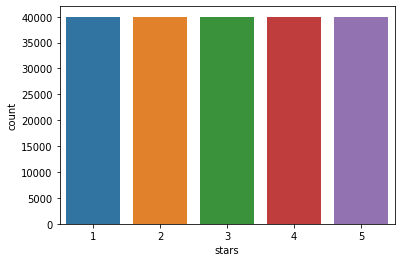

In [19]:
#Contamos con un dataset perfectamente balanceado
sns.countplot(dataset.stars) 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

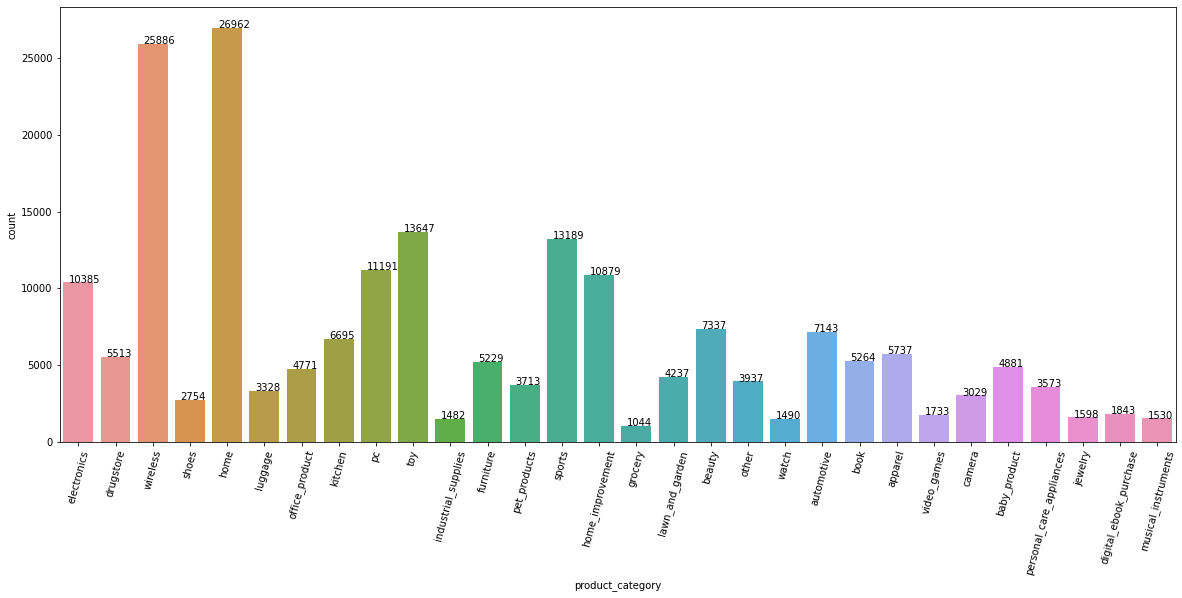

In [20]:
#La cantidad de productos por categoria
plt.figure(figsize=(20,8))
ax=sns.countplot(dataset.product_category)
ax.set_xticklabels(ax.get_xticklabels(),rotation=75)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
plt.show

In [21]:
tipos= dataset.product_category.unique()

In [22]:
dataset.stars[dataset.product_category=='toy'].mean()

3.0420605261229574

In [23]:
puntos=[]
for i in range(0,len(tipos)):
  puntos.append(dataset.stars[dataset.product_category==tipos[i]].mean())
  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

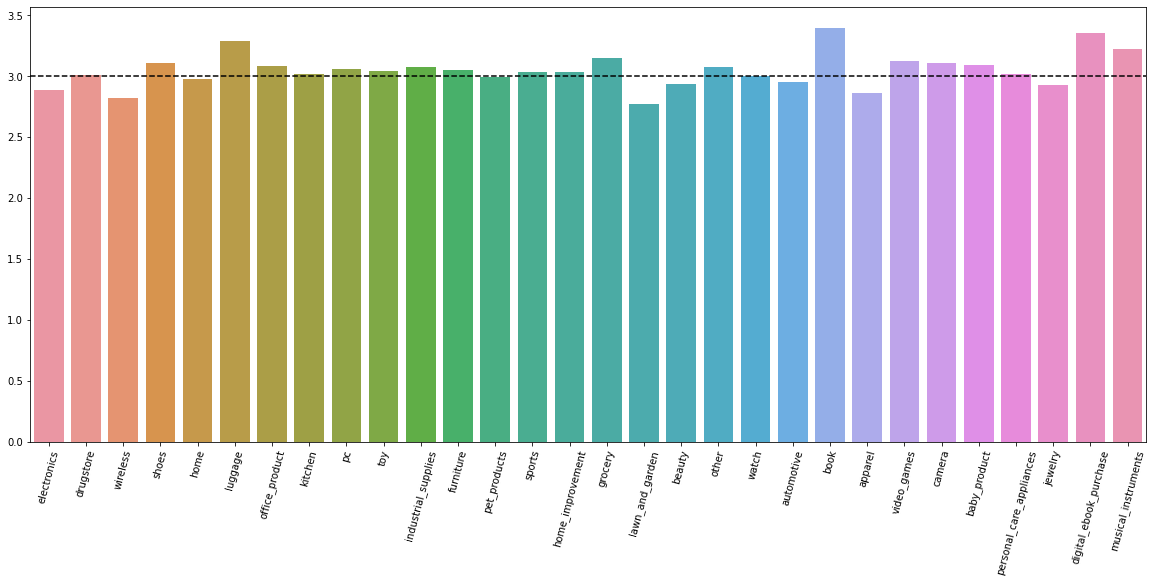

In [24]:
# El promedio general comparado con el promedio de los puntajes de cada categoria
plt.figure(figsize=(20,8))
ax=sns.barplot(dataset.product_category.unique(),puntos)
ax.set_xticklabels(ax.get_xticklabels(),rotation=75)
plt.axhline(y=dataset.stars.mean(), color='k', linestyle='--')
plt.show

In [25]:
dataset.language.unique()

array(['es'], dtype=object)

In [26]:
dataset.product_category.unique()

array(['electronics', 'drugstore', 'wireless', 'shoes', 'home', 'luggage',
       'office_product', 'kitchen', 'pc', 'toy', 'industrial_supplies',
       'furniture', 'pet_products', 'sports', 'home_improvement',
       'grocery', 'lawn_and_garden', 'beauty', 'other', 'watch',
       'automotive', 'book', 'apparel', 'video_games', 'camera',
       'baby_product', 'personal_care_appliances', 'jewelry',
       'digital_ebook_purchase', 'musical_instruments'], dtype=object)

In [27]:
dataset.stars.unique()

array([1, 2, 3, 4, 5])

In [28]:
dataset=dataset.drop(['language','review_title','reviewer_id'],axis=1)

In [29]:
dataset.isna().sum()

review_id           0
product_id          0
stars               0
review_body         0
product_category    0
dtype: int64

Vamos a realizar un analisis de las palabras que más se repiten en los dos distintos tipos de reseñas (Positivo, Negativo y Neutro)

# Negativo

In [30]:
#Tokenización, pasado a minúscula y eliminación de stop words de cada elemento
negativo=dataset[(dataset.stars==1) | (dataset.stars==2)]


In [31]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]


In [33]:
#Tokenización, pasado a minúscula y eliminación de stop words de cada elemento
negativo_filtro = []
for i in range(negativo.shape[0]):
    body = negativo.iloc[i].review_body
    body=body.lower()
    body = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(body)
    body = [word for word in body if word not in stopwords]

    negativo_filtro.append(body)

In [34]:
#Pasado a lista y desarmado de cada elemento de la lista para separarlo por palabras
negativo_filtro = list(itertools.chain(*negativo_filtro))
negativo_filtro[0:10]

['bueno',
 'ka',
 'pantalla',
 'menos',
 '8',
 'meses',
 'recibido',
 'respuesta',
 'fabricante',
 'horrible']

In [35]:
#Frecuencia de cada palabra
freq_negativo = nltk.FreqDist(negativo_filtro)

In [36]:
#Armamos un dataset con la Frecuencia y las palabras
df_negativo = pd.DataFrame(list(freq_negativo.items()), columns = ["Word","Frequency"])
df_negativo.sort_values('Frequency',ascending=False, inplace = True)
df_negativo.reset_index(drop = True, inplace=True)
df_negativo.head()

,Word,Frequency
0,bien,14075
1,producto,11870
2,si,11318
3,calidad,10223
4,dos,6590


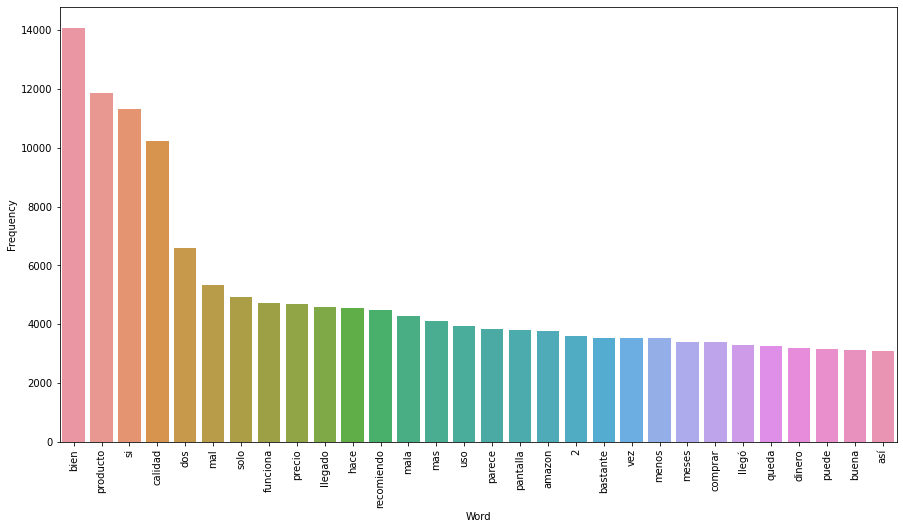

In [37]:
#Visualización
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_negativo.iloc[:30].Word, y = df_negativo.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

# Positivo

In [38]:
positivo=dataset[(dataset.stars==4) | (dataset.stars==5)]

In [39]:
#Tokenización, pasado a minúscula y eliminación de stop words de cada elemento
positivo_filtro = []
for i in range(positivo.shape[0]):
    body = positivo.iloc[i].review_body
    body=body.lower()
    body = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(body)
    body = [word for word in body if word not in stopwords]

    positivo_filtro.append(body)

In [40]:
#Pasado a lista y desarmado de cada elemento de la lista para separarlo por palabras
positivo_filtro = list(itertools.chain(*positivo_filtro))

In [41]:
#Frecuencia de cada palabra
freq_positivo = nltk.FreqDist(positivo_filtro)

In [42]:
#Armamos un dataset con la Frecuencia y las palabras
df_positivo = pd.DataFrame(list(freq_positivo.items()), columns = ["Word","Frequency"])
df_positivo.sort_values('Frequency',ascending=False, inplace = True)
df_positivo.reset_index(drop = True, inplace=True)
df_positivo.head()

,Word,Frequency
0,bien,23539
1,calidad,15739
2,buena,13130
3,precio,12876
4,producto,8791


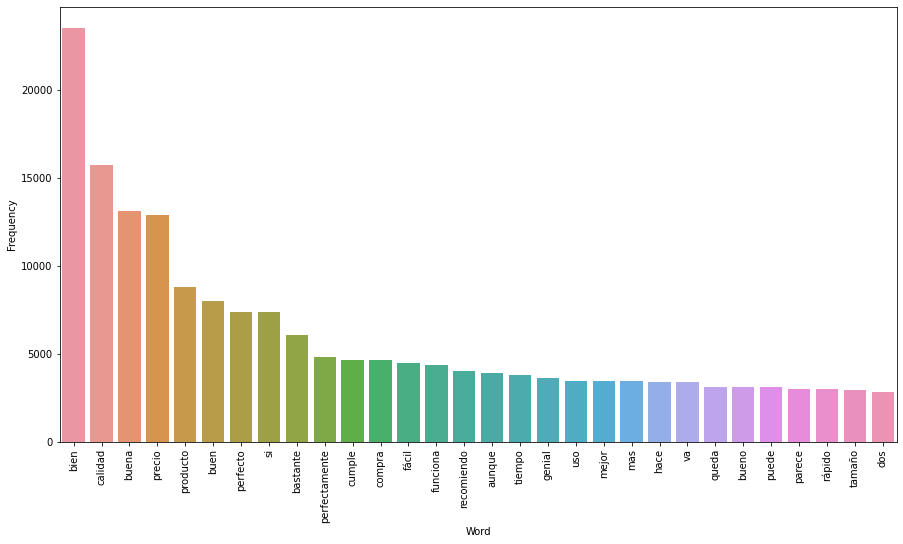

In [43]:
#Visualización
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_positivo.iloc[:30].Word, y = df_positivo.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

# Neutro

In [52]:
neutro=dataset[(dataset.stars==3)]

In [53]:
#Tokenización, pasado a minúscula y eliminación de stop words de cada elemento
neutro_filtro = []
for i in range(neutro.shape[0]):
    body = neutro.iloc[i].review_body
    body=body.lower()
    body = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(body)
    body = [word for word in body if word not in stopwords]

    neutro_filtro.append(body)

In [60]:
#Pasado a lista y desarmado de cada elemento de la lista para separarlo por palabras
neutro_filtro = list(itertools.chain(*neutro_filtro))

In [61]:
#Frecuencia de cada palabra
freq_neutro = nltk.FreqDist(neutro_filtro)

In [48]:
#Armamos un dataset con la Frecuencia y las palabras
df_neutro = pd.DataFrame(list(freq_neutro.items()), columns = ["Word","Frequency"])
df_neutro.sort_values('Frequency',ascending=False, inplace = True)
df_neutro.reset_index(drop = True, inplace=True)
df_neutro.head()

,Word,Frequency
0,bien,13948
1,si,6517
2,calidad,5967
3,precio,5376
4,producto,3973


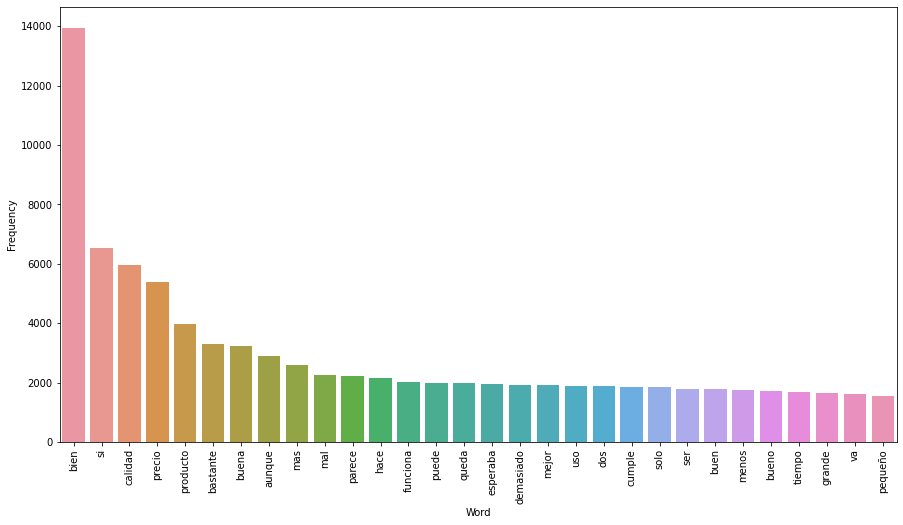

In [49]:
#Visualización
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_neutro.iloc[:30].Word, y = df_neutro.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Una complicación para los modelos es que muchas palabras se repiten tanto en las reseñas positivas como negativas (Ej: bien), esto va a confundir a los modelos a la hora de predecir.

# Transformacion de datos

Para el posterior analisis decidi deshacerme de las valoraciones de 3 ya que creo que no nos van a aportar nada y tambien agrupe en positivo a las valoraciones 4 y 5, y en negativo a las valoraciones 1 y 2. Esto si bien es una simplificación del problema, nos va a ser muy util para poder hacer modelos más precisos y para reducir el costo computacional de contar con más datos.

Decidi implementar esto ya que cuando trabaje con el dataset completo los resultados de todos los modelos eran muy pobres y dificiles de optimizar.

In [63]:
data=dataset

In [64]:
data.shape

(200000, 5)

In [65]:
#Nos deshacemos de las reseñas de 3 estrellas
data=data[data.stars!=3]

In [66]:
data.shape

(160000, 5)

In [67]:
data=data.replace({'stars' : { 1 : 'Negativo', 2 : 'Negativo', 4 : 'Positivo',5:'Positivo' }})


In [68]:
#Cargamos el WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [69]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [70]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [71]:
#Función para eliminar tildes
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

In [72]:
#Función para asignarle a cada palabra su función en el texto
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

## Train-Test Split 

In [74]:
reviews_limpio=[]
for reviews in data.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    reviews=elimina_tildes(reviews)
    reviews=re.sub("[^a-zA-Z]"," ",str(reviews))
    # Pasamos todo a minúsculas
    reviews=reviews.lower()
    # Tokenizamos para separar las palabras
    reviews=nltk.word_tokenize(reviews)
    
    # Aplicamos el Lemmatizer
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in reviews]
    
    
    # Eliminamos las palabras de menos de 3 letras
    reviews = [palabra for palabra in reviews if len(palabra)>3]
    # Sacamos las Stopwords
    reviews = [palabra for palabra in reviews if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    reviews=" ".join(reviews)
    #dataset["titular_normalizado"] = titular_list
    reviews_limpio.append(reviews)

In [75]:
#Nueva columna en el dataset con las reseñas "limpias"
data["reviews_lem"] = reviews_limpio
data.tail()

,review_id,product_id,stars,review_body,product_category,reviews_lem
199995,es_0715276,product_es_0317036,Positivo,Mando funciona perfectamente y cumple con toda...,electronics,mando funciona perfectamente cumple todas func...
199996,es_0085190,product_es_0622919,Positivo,"Compré la batería con cierta reticencia, pero ...",electronics,compre bateria cierta reticencia resulto facil...
199997,es_0484496,product_es_0358101,Positivo,Buena calidad. Satisfecha con la compra.,apparel,buena calidad satisfecha compra
199998,es_0930141,product_es_0788855,Positivo,Perfecto para el cumple de mi hijo,toy,perfecto cumple hijo
199999,es_0859809,product_es_0378794,Positivo,"Súper bien! Las brochas son buenas, no sé meno...",home,super bien brochas buenas menos caido pelitos ...


In [76]:
df=data

In [77]:
df=df.drop(['review_id','product_id','review_body','product_category'],axis=1)

In [78]:
#Armamos y con las puntuaciones de las reseñas y una lista con las reseñas
list_reviews = list(df['reviews_lem'].values)
y_train = df['stars'].values

In [80]:
#Para vectorizar cada palabra, utilizamos solo 1000 palabras
max_features=1000

cou_vec=CountVectorizer(max_features=max_features)

In [85]:
#Vectorización de las palabras, el resultado va a ser que cada reseña tenga su matriz con las 1000 palabras
X_train = cou_vec.fit_transform(list_reviews)
X_train=X_train.toarray()

### Para test

In [90]:
test=data_test

In [91]:
test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


In [92]:
test=test[test.stars!=3]

In [93]:
test=test.replace({'stars' : { 1 : 'Negativo', 2 : 'Negativo', 4 : 'Positivo',5:'Positivo' }})

In [94]:
reviews_limpio=[]
for reviews in test.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios 
    reviews=elimina_tildes(reviews)
    reviews=re.sub("[^a-zA-Z]"," ",str(reviews))
    # Pasamos todo a minúsculas
    reviews=reviews.lower()
    # Tokenizamos para separar las palabras
    reviews=nltk.word_tokenize(reviews)
    
    # Aplicamos el Lemmatizer
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in reviews]
    
    
    # Eliminamos las palabras de menos de 3 letras
    reviews = [palabra for palabra in reviews if len(palabra)>3]
    # Sacamos las Stopwords
    reviews = [palabra for palabra in reviews if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    reviews=" ".join(reviews)
    #dataset["titular_normalizado"] = titular_list
    reviews_limpio.append(reviews)

In [95]:
#Nueva columna en el dataset con las reseñas "limpias"
test["reviews_lem"] = reviews_limpio
test.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,reviews_lem
4995,es_0685611,product_es_0919143,reviewer_es_0461769,Positivo,Para lo que cuesta es perfecto porque cumple s...,Perfectos para lo que sirven,es,wireless,cuesta perfecto cumple funcion sobra ademas pe...
4996,es_0638242,product_es_0636134,reviewer_es_0214562,Positivo,"Material muy flexible y cómodo, acorde a la de...","Buen vendedor, rápido y fiable.",es,wireless,material flexible comodo acorde descripcion
4997,es_0760108,product_es_0078583,reviewer_es_0043609,Positivo,Se ve bien el grabado,medallas con bonito grabado,es,home,bien grabado
4998,es_0070806,product_es_0359350,reviewer_es_0258717,Positivo,lo compré para mi bici pero finalmente se lo h...,timbre,es,sports,compre bici finalmente quedado xiaomi scooter ...
4999,es_0794544,product_es_0130307,reviewer_es_0651938,Positivo,Pues este tipo de cascos si que son inalambric...,Auriculares sin cables de verdad,es,electronics,pues tipo cascos inalambricos verdad atados go...


In [96]:
#Armamos y con las puntuaciones de las reseñas y una lista con las reseñas
list_reviews = list(test['reviews_lem'].values)
y_test = test['stars'].values

In [97]:
#Vectorización de las palabras, el resultado va a ser que cada reseña tenga su matriz con las 1000 palabras
X_test = cou_vec.transform(list_reviews)
X_test=X_test.toarray()

# Modelos

In [98]:
#Función para evaluar la matriz de confusión, precisión y exhaustividad
def confusion(y_test,y_test_pred):
    names=["Negativo","Positivo"]
    print(classification_report(y_test, y_test_pred, target_names=names))
    cm=confusion_matrix(y_test,y_test_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.xlabel("y_test_pred")
    plt.ylabel("y_true")
    plt.show()

    return

## Naive Bayes

### Modelo que vamos a usar como Benchmark

In [99]:
#Traemos y entrenamos el modelo
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [100]:
#Predicciones
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

In [101]:
#Evaluación con accuracy score sobre test y train
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aceirtos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aceirtos sobre el set de evaluación:',test_acc)

Porcentaje de aceirtos sobre el set de entrenamiento: 0.767725
Porcentaje de aceirtos sobre el set de evaluación: 0.771


              precision    recall  f1-score   support

    Negativo       0.85      0.66      0.74      2000
    Positivo       0.72      0.88      0.79      2000

    accuracy                           0.77      4000
   macro avg       0.78      0.77      0.77      4000
weighted avg       0.78      0.77      0.77      4000



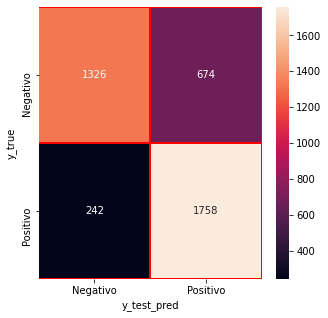

In [102]:
#Matriz de confusión, precisión y exhaustividad
confusion(y_test,y_test_pred)

## Random Forest

In [105]:
#Traemos y entrenamos el modelo
rf = RandomForestClassifier(n_estimators = 100, random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [106]:
#Predicciones
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [107]:
#Evaluación con accuracy score sobre test y train
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aceirtos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aceirtos sobre el set de evaluación:',test_acc)

Porcentaje de aceirtos sobre el set de entrenamiento: 0.98595
Porcentaje de aceirtos sobre el set de evaluación: 0.83325


              precision    recall  f1-score   support

    Negativo       0.84      0.82      0.83      2000
    Positivo       0.82      0.85      0.84      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



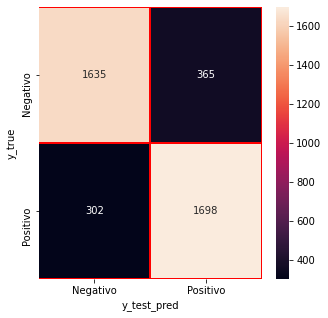

In [108]:
#Matriz de confusión, precisión y exhaustividad
confusion(y_test,y_test_pred)

## SVC

In [109]:
#Traemos y entrenamos el modelo
svc = LinearSVC(C = 1)
svc.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [110]:
#Predicciones
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

In [111]:
#Evaluación con accuracy score sobre test y train
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aceirtos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aceirtos sobre el set de evaluación:',test_acc)

Porcentaje de aceirtos sobre el set de entrenamiento: 0.84894375
Porcentaje de aceirtos sobre el set de evaluación: 0.847


              precision    recall  f1-score   support

    Negativo       0.84      0.85      0.85      2000
    Positivo       0.85      0.84      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



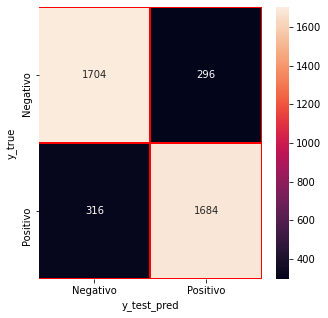

In [112]:
#Matriz de confusión, precisión y exhaustividad
confusion(y_test,y_test_pred)

# Random Search CV

### Como Support Vector Classification fue el modelo que mejor resultado y funcionó más rapido que Random Forest, va a ser el modelo que voy a optimizar.

In [113]:
#Parametros
parametros = {'C': [0.1,1, 10, 100],'loss':['hinge', 'squared_hinge'],'max_iter':[500,1000,1500,2000]}

In [114]:
model = RandomizedSearchCV(svc,parametros, random_state=0, cv=5,n_jobs=-1,n_iter=25)
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                       fit_intercept=True, intercept_scaling=1,
                                       loss='squared_hinge', max_iter=1000,
                                       multi_class='ovr', penalty='l2',
                                       random_state=None, tol=0.0001,
                                       verbose=0),
                   iid='deprecated', n_iter=25, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': [500, 1000, 1500, 2000]},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [115]:
#Mejores parametros para utilizar
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)


Mejores parametros: {'max_iter': 1000, 'loss': 'hinge', 'C': 10}
Mejor Score: 0.83716875



In [116]:
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,param_loss,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.890843,0.231162,0.148605,0.004570,2000,hinge,1,"{'max_iter': 2000, 'loss': 'hinge', 'C': 1}",0.851250,0.851125,0.841875,0.819625,0.820438,0.836862,0.014159,2
1,71.560073,0.872001,0.130583,0.010218,1500,squared_hinge,10,"{'max_iter': 1500, 'loss': 'squared_hinge', 'C...",0.851094,0.850656,0.840531,0.818781,0.820812,0.836375,0.014068,14
2,6.098424,0.188649,0.134422,0.012221,1500,hinge,1,"{'max_iter': 1500, 'loss': 'hinge', 'C': 1}",0.851250,0.851156,0.841844,0.819562,0.820281,0.836819,0.014215,3
3,2.471722,0.066378,0.138303,0.000754,1500,hinge,0.1,"{'max_iter': 1500, 'loss': 'hinge', 'C': 0.1}",0.850969,0.850406,0.841469,0.817937,0.819219,0.836000,0.014624,17
4,19.441174,0.318555,0.135607,0.008036,500,hinge,10,"{'max_iter': 500, 'loss': 'hinge', 'C': 10}",0.852281,0.849906,0.841219,0.818656,0.817906,0.835994,0.014926,18
5,64.335200,1.229425,0.153807,0.016234,1500,squared_hinge,1,"{'max_iter': 1500, 'loss': 'squared_hinge', 'C...",0.851219,0.851406,0.840875,0.819156,0.819719,0.836475,0.014425,9
6,31.941631,0.151418,0.164352,0.001618,500,squared_hinge,100,"{'max_iter': 500, 'loss': 'squared_hinge', 'C'...",0.834906,0.800500,0.804156,0.784250,0.785813,0.801925,0.018258,25
7,79.693531,1.290742,0.166988,0.003033,1500,hinge,100,"{'max_iter': 1500, 'loss': 'hinge', 'C': 100}",0.855031,0.846281,0.836812,0.814750,0.804438,0.831462,0.019044,19
8,29.060865,0.309293,0.159746,0.014266,500,squared_hinge,10,"{'max_iter': 500, 'loss': 'squared_hinge', 'C'...",0.852000,0.848688,0.840281,0.819594,0.820000,0.836112,0.013859,15
9,43.647838,0.573697,0.161503,0.007794,1000,squared_hinge,1,"{'max_iter': 1000, 'loss': 'squared_hinge', 'C...",0.851219,0.851437,0.840906,0.819187,0.819813,0.836513,0.014404,8


In [117]:
scores.mean_fit_time.sum()/60

16.560076530774435

In [118]:
#Predicción con nuestro nuevo modelo optimizado
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [119]:
#Evaluación con accuracy score sobre test y train
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Porcentaje de aceirtos sobre el set de entrenamiento:', train_acc)
print('Porcentaje de aceirtos sobre el set de evaluación:',test_acc)

Porcentaje de aceirtos sobre el set de entrenamiento: 0.85039375
Porcentaje de aceirtos sobre el set de evaluación: 0.84625


              precision    recall  f1-score   support

    Negativo       0.84      0.85      0.85      2000
    Positivo       0.85      0.84      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



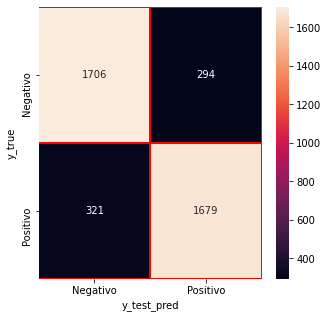

In [120]:
#Matriz de confusión, precisión y exhaustividad
confusion(y_test,y_test_pred)

La optimización de parametros no fue muy eficaz ya que el modelo no mejoro casi nada con respecto al anterior.

# Development

### Por ultimo vamos a evaluar nuestro modelo con el development 

In [121]:
dev=data_dev

In [122]:
dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [123]:
dev.shape

(5000, 8)

In [124]:
dev=dev[dev.stars!=3]

In [125]:
dev=dev.replace({'stars' : { 1 : 'Negativo', 2 : 'Negativo', 4 : 'Positivo',5:'Positivo' }})

In [126]:
reviews_limpio=[]
for reviews in dev.review_body:
    # Vamos a reemplzar los caracteres que no sean letras por espacios 
    reviews=elimina_tildes(reviews)
    reviews=re.sub("[^a-zA-Z]"," ",str(reviews))
    # Pasamos todo a minúsculas
    reviews=reviews.lower()
    # Tokenizamos para separar las palabras
    reviews=nltk.word_tokenize(reviews)
    
    # Aplicamos el Lemmatizer
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in reviews]
    
    
    # Eliminamos las palabras de menos de 3 letras
    reviews = [palabra for palabra in reviews if len(palabra)>3]
    # Sacamos las Stopwords
    reviews = [palabra for palabra in reviews if not palabra in stopwords]
    
    # Por ultimo volvemos a unir el titular
    reviews=" ".join(reviews)
    #dataset["titular_normalizado"] = titular_list
    reviews_limpio.append(reviews)

In [127]:
dev["reviews_lem"] = reviews_limpio
dev.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,reviews_lem
4995,es_0179515,product_es_0158275,reviewer_es_0273644,Positivo,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,encantado cesta llegado impecable tamano util ...
4996,es_0894902,product_es_0953259,reviewer_es_0153773,Positivo,Desempeña su función correctamente,calidad precio,es,camera,desempena funcion correctamente
4997,es_0760496,product_es_0731995,reviewer_es_0171091,Positivo,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,encantado diadema flores vienen imagen venian ...
4998,es_0178380,product_es_0402051,reviewer_es_0686937,Positivo,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,gustan fundas fundas normalmente finas colorid...
4999,es_0810087,product_es_0684221,reviewer_es_0613091,Positivo,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel,articulo cumplido expectativas deseaba


In [128]:
#Armamos y con las puntuaciones de las reseñas y una lista con las reseñas
list_reviews = list(test['reviews_lem'].values)
y_dev = dev['stars'].values

In [129]:
#Vectorización de las palabras, el resultado va a ser que cada reseña tenga su matriz con las 1000 palabras
X_dev = cou_vec.transform(list_reviews)
X_dev=X_dev.toarray()

In [130]:
#Predicción
y_dev_pred = model.predict(X_dev)

In [131]:
#Accuracy
dev_acc = accuracy_score(y_dev, y_dev_pred)

print('Porcentaje de aceirtos sobre el set de evaluación:',dev_acc)

Porcentaje de aceirtos sobre el set de evaluación: 0.84625


              precision    recall  f1-score   support

    Negativo       0.84      0.85      0.85      2000
    Positivo       0.85      0.84      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



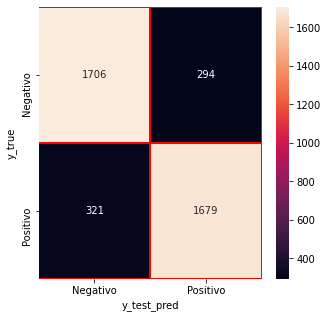

In [132]:
#Matriz de confusión, precisión y exhaustividad
confusion(y_dev,y_dev_pred)

Buen puntaje del modelo y correctas predicciones, casi iguales a las del test.

# Conclusión

Para resumir nos deshicimos de las valoraciones de 3 estrellas, agrupamos en Positivo las reseñas de 4 y 5 estrellas, y en negativo las valoraciones de 1 y 2 estrellas. Este cambio significo una mejora de los modelos y mayor rapidez en procesamiento de los modelos. 

Por el otro lado ya no sabemos con qué exactitud le gusto el producto (si mucho o poco) y perdemos información al eliminar las criticas intermedias. Además esto puede llevar a que hayamos sobre-simplificado el problema.

El resultado fue muy bueno ya que pude hacer un modelo eficaz que prediga correctamente si la reseña del usurario es positiva o negativa. 

La utilidad de esto ya se puede ver por ejemplo en las reseñas de Mercado Libre que automaticamente le permite a uno filtrar las reseñas de un producto agrupando las positivas por un lado y las negativas.

Por ultimo a modo de investigación seria bueno seguir probando con el dataset entero, utilizar la forma de puntuación original y poder realizar un modelo que prediga correctamente las puntuaciones.
